# Otsu Thresholding
 In scientific image processing it almost always important to separate the observed objects from their background. This 
 is complicated by inhomogeneity and noise of the background. Thresholding is a method which binarizes images by 
 assigning eache pixel ($p$) to one of two values (mostly range $max(=L)$ or $min(=0)$) due to its original value($v$). 
 Therefore a value needs to be defined as threshold ($k$) for separation of pixels being brighter 
 ($v_{p}>k \to v_{p}=v_{max}$) or darker ($v_{p}<=k \to v_{p}=v_{0}$). The difficulty at this point is to find a proper 
 threshold to separate dark and bride so that the whole background but just the background is assigned as background.     
 
 In 1979 Nobuyuki Otsu published a paper that describes a method to find a threshold giving a very good separation of 
 pixels. This achieved by computing each threshold    
...




## Data set  
The given data set  BBBC020 from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012] consists 
of 25 times 3 images of macrophages. Two channels took images of the cell membrane stained with CD11b/APC and the 
nucleus stained with DAPI. The third version of each of the 25 images is a merge of the two channels.

In this project I focused on the nuclei. 
An example is shown below after unzipping and arranging a folder that can be worked with easily.  


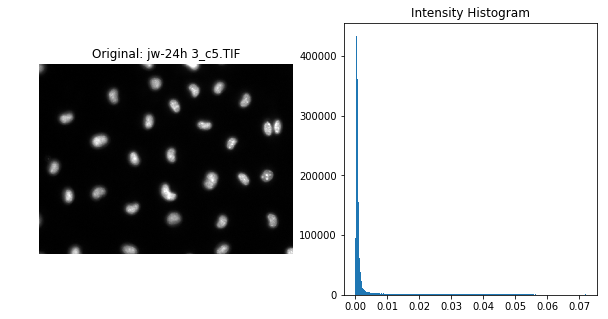

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
import skimage.io
import skimage.filters
import dice as dic
import get_im as im
import enhance as enh
import re

testing = 'BBBC020_v1_images.zip'
im.create_unzipped_files_if_there_are_no(testing, 'all images')
image_directory = 'all images/BBBC020_v1_images/'
path_list, name_list = im.image_path_name_list(image_directory, '24h 3_c5.TIF')

figure_original, axes = plt.subplots(1, 2, figsize=(10, 5))
original_image = im.import_image(path_list[0])
axes[0].imshow(original_image, cmap=plt.cm.gray)
axes[0].set_title('Original: ' + name_list[0])
axes[0].axis('off')

axes[1].hist(original_image.ravel(), bins=256)
axes[1].set_title('Intensity Histogram')
# axes[1].ylabel('Pixel number')
# axes[1].xlabel('Intensity')

plt.show()


## Example of Thresholding
Shown below is the original image and the Otsu tresholden one. Also illustrated is the appearance of the same image with
a critically low and high threshold. Notice the unrepresentative large area the nuclei occupy with a low threshold. By 
decreasing the threshold further, nuclei will grow together and brighter spots deriving from background noise will 
appear. With a too high threshold it is reverse. Nuclei will divide into those spots within a nucleus peacing the images
spectrum.    
  


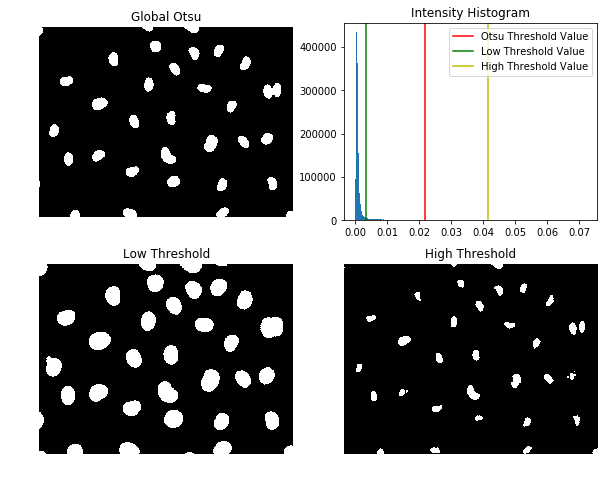

In [3]:
import skimage.filters

thresh_value = skimage.filters.threshold_otsu(original_image)
binary_otsu = original_image > thresh_value

binary_low = original_image > thresh_value*0.15
binary_high = original_image > thresh_value*1.9 

figure_thresholds, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0][0].imshow(binary_otsu, cmap=plt.cm.gray)
axes[0][0].set_title('Global Otsu')
axes[0][0].axis('off')

axes[0][1].hist(original_image.ravel(), bins=256)
axes[0][1].set_title('Intensity Histogram')
axes[0][1].axvline(thresh_value, color='r', label='Otsu Threshold Value')
axes[0][1].axvline(thresh_value*0.15, color='g', label='Low Threshold Value')
axes[0][1].axvline(thresh_value*1.9, color='y', label='High Threshold Value')
axes[0][1].legend()

axes[1][0].imshow(binary_low, cmap=plt.cm.gray)
axes[1][0].set_title('Low Threshold')
axes[1][0].axis('off')

axes[1][1].imshow(binary_high, cmap=plt.cm.gray)
axes[1][1].set_title('High Threshold')
axes[1][1].axis('off')

plt.show()



## Control Data Set 
The given control data set consist of binary valued ($b/w$) images showing always one nucleus for easier segmentation 
evaluation.   


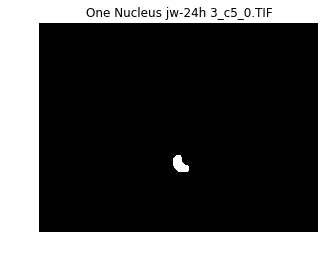

In [4]:
control = 'BBBC020_v1_outlines_nuclei.zip'
im.create_unzipped_files_if_there_are_no(control, 'all controls')
control_directory = 'all controls/BBC020_v1_outlines_nuclei/'
path_list_control, name_list_control = im.image_path_name_list(control_directory, '24h 3_c5_0.TIF')

figure_single_nucleus, axes = plt.subplots(1, 1, figsize=(5, 5))
control_nucleus = im.import_image(path_list_control[0])
axes.imshow(control_nucleus, cmap=plt.cm.gray)
axes.set_title('One Nucleus ' + name_list_control[0])
axes.axis('off')
plt.show()



For the purpose of thresholding these images need to be assembled to one image containing all nuclei of the control data
set. 


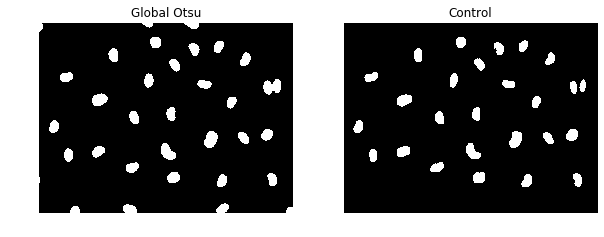

In [5]:
import get_im as im
import re

control_search_filter = re.compile('.*24h 3_c5.TIF'[:-4]+'.*')
binary_control, optimal_counter = im.assemble_import_control_image(control_directory, control_search_filter)

figure_control, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[1].imshow(binary_control, cmap=plt.cm.gray)
axes[1].set_title('Control')
axes[1].axis('off')

axes[0].imshow(binary_otsu, cmap=plt.cm.gray)
axes[0].set_title('Global Otsu')
axes[0].axis('off')

plt.show()




It can already be seen that nuclei reaching out of the frame were cut as well as nuclei that could not be separated out
 since they are not appropriate for segmentation. This will disturb our Dice score in later processing. Also notice the
 inferior separation of the two nuclei in the upper right.    

## Getting the matches

Visualization of differences between the otsu threscholded original image and the given optimum. Differences are shown 
in black, similarities in white ($b$&$b \to w$) ($w$&$w \to w$) ($w$&$b \to b$) ($b$&$w \to b$)

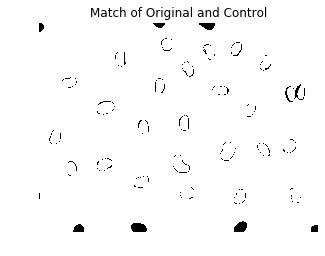

In [6]:
import dice as dic

match = dic.creation_of_match_array(binary_otsu, binary_control)

figure_match, axes = plt.subplots(1, 1, figsize=(5, 5))

axes.imshow(match, cmap=plt.cm.gray)
axes.set_title('Match of Original and Control')
axes.axis('off')
plt.show()


## Calculation of Dice score 
The Dice score is calculated as follows. Notice that the score resembles not the percentage of correct assigned pixels.

$$Ds=\frac{2w}{2w+b}$$

The Dice score from the above shown match is calculated.



In [8]:
dice_score_global = dic.dice_score(binary_otsu, binary_control)
print('Global Dice score: ', dice_score_global)


Global Dice score:  0.9903929544602541


# Increasing the Dice score 
Several methods were used and the effect on the Dice score documented. 
* Application of Local Otsu Thresholding at different loci-sizes
* Gaussian filtering with different sigma values and median filtering with each pixels eight surrounding pixels 
* Edge detection and addition (edging)

### Local Otsu Thresholding
Otsu thresholding is applied on each pixel giving it a threshold defined by its surrounding within a certain radius. 



C:\Users\User\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


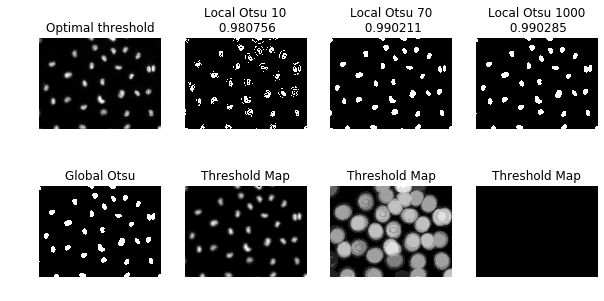

In [9]:
import enhance as enh

figure_local, axes = plt.subplots(2, 4, figsize=(10, 5))
radius_list = [10, 70, 1000]

axes[1][0].imshow(binary_otsu, cmap=plt.cm.gray)
axes[1][0].set_title('Global Otsu')
axes[1][0].axis('off')

axes[0][0].imshow(original_image, cmap=plt.cm.gray)
axes[0][0].set_title('Optimal threshold')
axes[0][0].axis('off')

for dx, radius in enumerate(radius_list, 1):
    local_otsu, otsu_mask = enh.local_otsu(original_image, radius)
    match_local = dic.creation_of_match_array(local_otsu, binary_control)
    dice_score_local = dic.dice_score(local_otsu, binary_control)
    score_increase = dice_score_local - dice_score_global
    
    axes[0][dx].imshow(local_otsu, cmap=plt.cm.gray)
    axes[0][dx].set_title(f'Local Otsu {radius}\n {round(dice_score_local, 6)}')
    axes[0][dx].axis('off')
    
    axes[1][dx].imshow(otsu_mask, cmap=plt.cm.gray)
    axes[1][dx].set_title('Threshold Map')
    axes[1][dx].axis('off')
    
plt.show()


A too small radius causes the threshold at the outer surrounding of the nuclei to drop under the nucleus blur. This 
causes halos which can be seen in 'Local Otsu 10'. A very large radius acts equal as global thresholding but consumes 
unnecessary computing resources.
In order to find the optimal size for the radius of local thresholding on the data set I plotted the mean Dice score 
against different radii.


In [11]:
import improvements as imp
print('do later, takes too long') 
# imp.optimal_local_otsu()


do later, takes too long


### Filtering
Gaussian filtering was performed at different sigma values giving no increase.

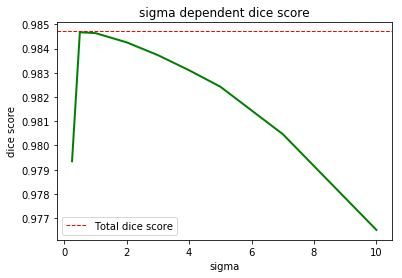

In [12]:
imp.display_improve_gaussian_filter()


Median filtering revealed a an increase of more than 0.004 which is over 25% of the deviation.    


In [3]:
imp.display_improve_median_filter()


C:\Users\User\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Dice score after median filtering 0.9889528785727169
Dice score increase:  0.004213858235344592


### Overlaying edges
The idea hear is to detect the edges of an image and its nuclei and overlay them with the original before thresholding 
to increase the contrast of the area where nucleus and background are meeting. The Sobel filter is used since it is a 
simple method to observe the effect of "edging" the image. The figure below again refers to the images 24h 3. However,
the mean scores at the bottom refer to the complete data set.  


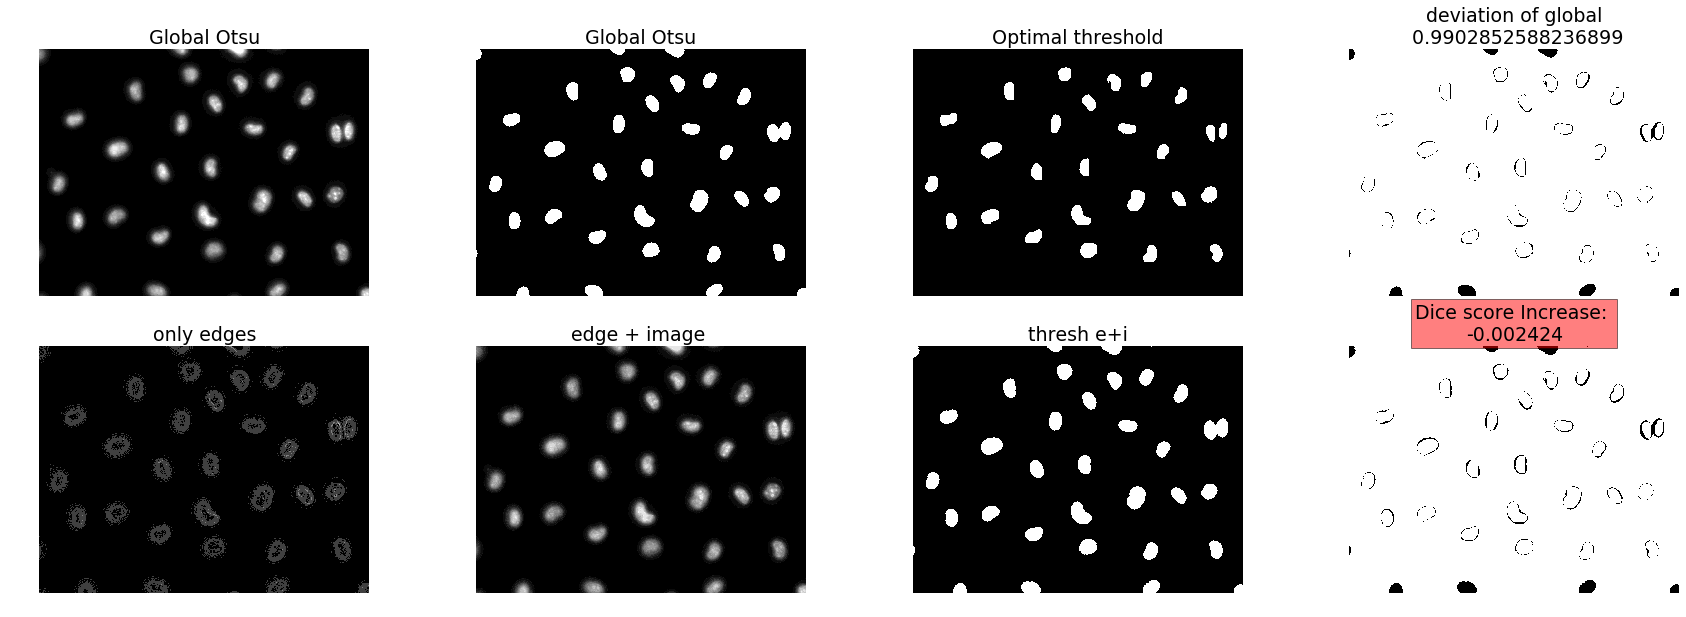

Dice score mean after overlaying the edges:  0.9819265793795561
Dice score mean global:  0.9847390203373723
Increase:  -0.002812440957816187


In [4]:
imp.increase_add_edge()


## Application
To show a possible application I performed image segmentation and its necessary preparing. To ensure that no small 
objects deriving from the thresholded inhomogeneous background or the nucleus blur were counted and assigned as nucleus 
a minimal size for objects was set. Every object being smaller was erased. Afterwards every coherent island of pixels 
with a value bigger than zero(background) was declared as one object(nucleus) and coloured. All objects were counted. 
Notice the effect that different thresholding methods have not just on nucleus size(Dice score) but also on their number.     


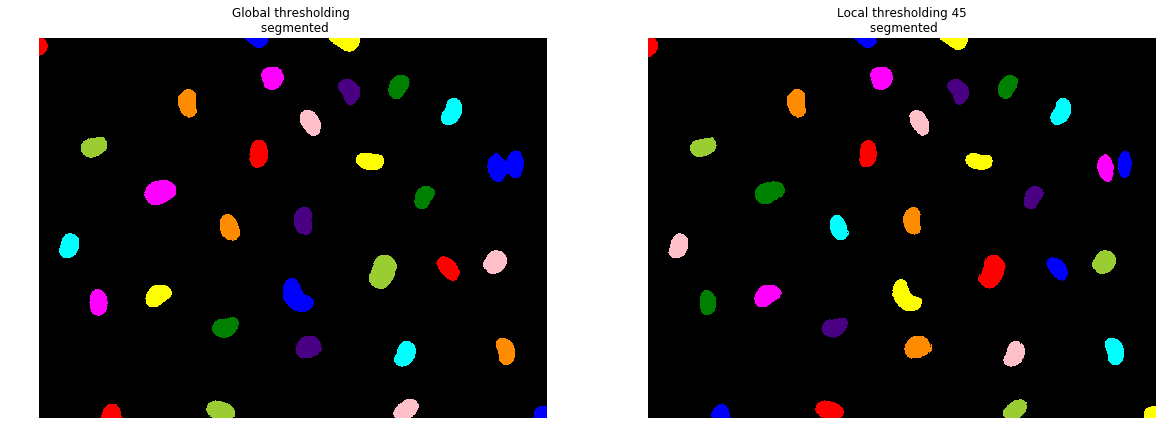

Nucleus number after Global Otsu:  32
Nucleus number after Local Otsu:  33


In [13]:
from scipy import ndimage as ndi
from skimage.color import label2rgb

cleaned_original = enh.small_obj_deletion(binary_otsu, 900)
g_segmented, global_count = ndi.label(cleaned_original)
coloured_global = label2rgb(g_segmented, bg_label=0, bg_color=(0, 0, 0))

local_otsu, mask = enh.local_otsu(original_image, 45)
local_otsu = enh.small_obj_deletion(local_otsu, 900)
l_segmented, local_count = ndi.label(local_otsu)
coloured_local = label2rgb(l_segmented, bg_label=0, bg_color=(0, 0, 0))
 
figure, axes = plt.subplots(1, 2, figsize=(20, 40))

axes[0].imshow(coloured_global, cmap=plt.cm.gray)
axes[0].set_title(f'Global thresholding \n segmented')
axes[0].axis('off')

axes[1].imshow(coloured_local, cmap=plt.cm.gray)
axes[1].set_title(f'Local thresholding 45\n segmented')
axes[1].axis('off')

plt.show()
print('Nucleus number after Global Otsu: ', global_count)
print('Nucleus number after Local Otsu: ', local_count)



## bringing it all together


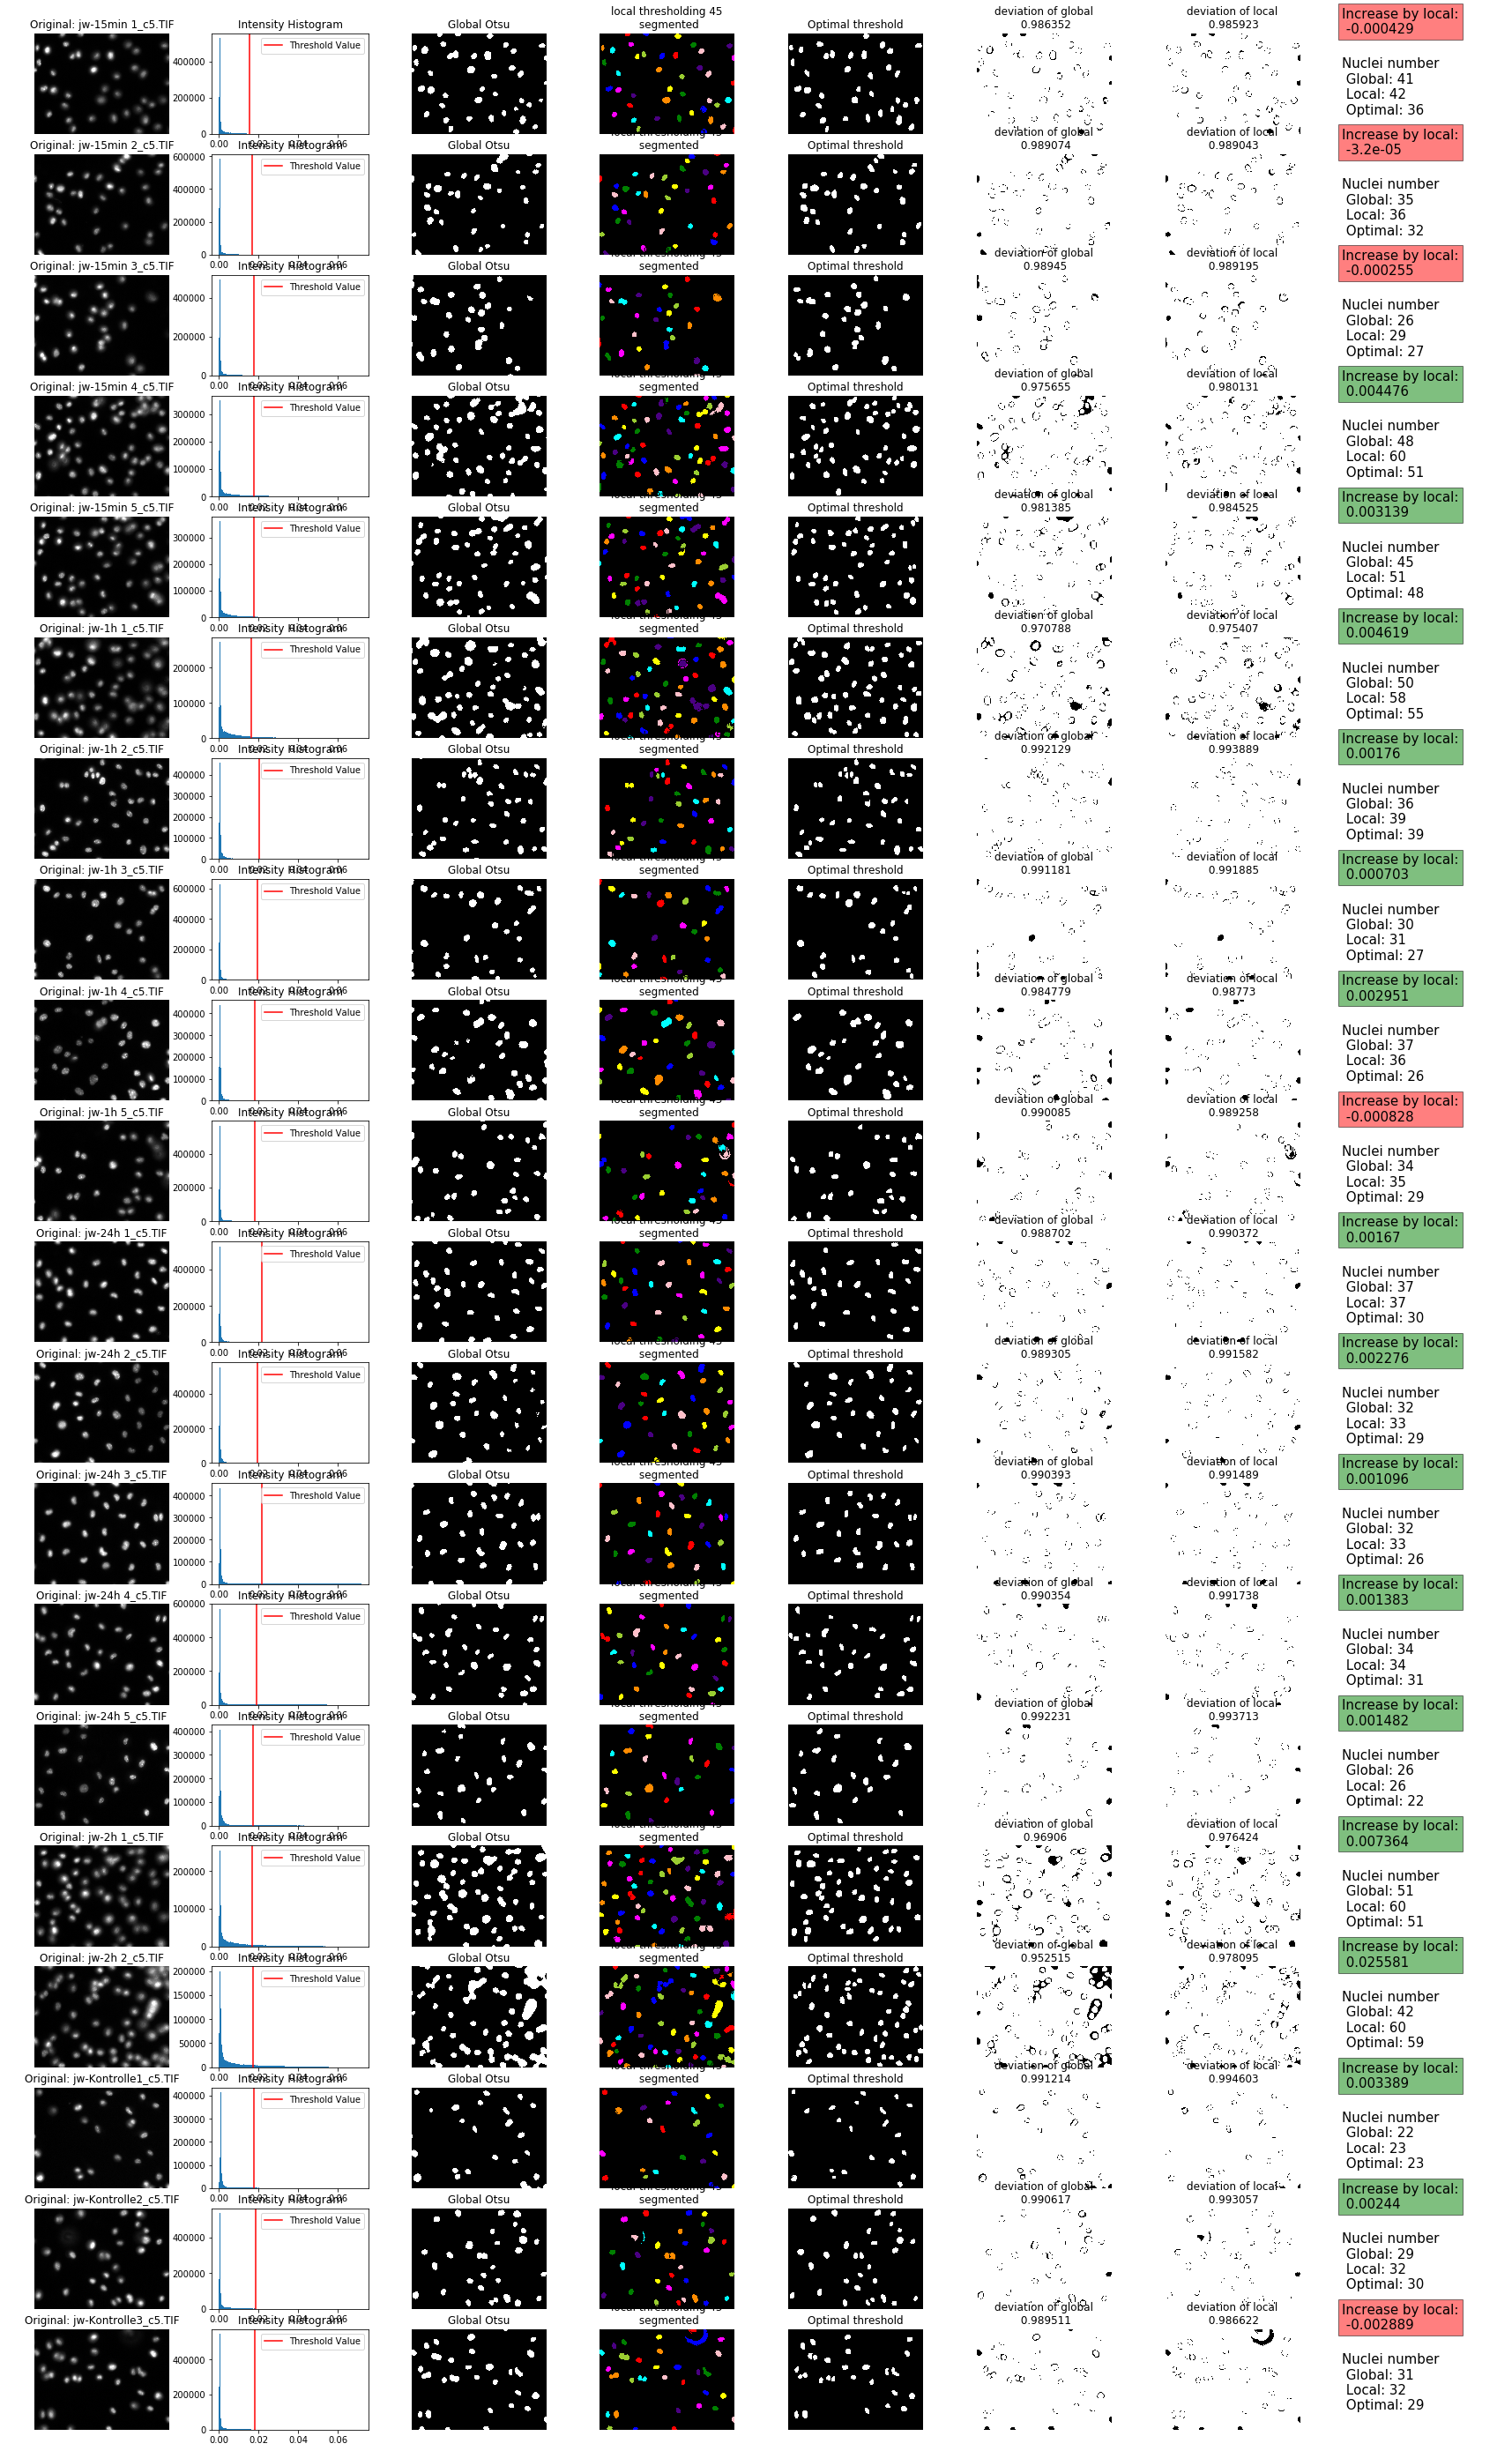

Total dice score:  0.9847390203373723


In [14]:
import Otsu_Thresholding as otsu
otsu.main()